In [ ]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df=pd.read_excel("/content/drive/MyDrive/Dataset/data1.xlsx")

In [ ]:
df.head()

System Code Crash Date Crash Time              City     County  Latitude  Longitude  \
0  State Highway 2021-01-01   00:00:00  GLENWOOD SPRINGS   GARFIELD  39.52549 -107.32253   
1    County Road 2021-01-01   00:05:00               NaN   LA PLATA       NaN        NaN   
2    City Street 2021-01-01   00:17:00       WESTMINSTER  JEFFERSON  39.82885 -105.04402   
3    City Street 2021-01-01   00:25:00            DENVER     DENVER  39.70461 -105.01356   
4    County Road 2021-01-01   00:26:00               NaN  JEFFERSON       NaN        NaN   

           Location 1 Location 2      Road Description Road Condition Lighting Conditions  \
0      SOUTH GLEN AVE    27TH ST  Intersection Related          Snowy            Daylight   
1              CR 228       MM 4      Non-Intersection            Icy    Dark – Unlighted   
2        TENNYSON ST   74TH AVE       Non-Intersection            Dry    Dark – Unlighted   
3  2200 BLK W GILL PL  S ZUNI ST      Non-Intersection            Dry    Dark – Unlighted   
4          W 32ND AVE  W 37TH DR  Intersection Related            Dry    Dark – Unlighted   

  Weather Condition  Rush Hour Alcohol Suspected Speed Limit Category Severity  
0              Snow          0                No                  Low   slight  
1             Clear          0                No                  Low   slight  
2             Clear          0                No                  Low   slight  
3             Clear          0                No                  Low   slight  
4             Clear          0                No                  Low   slight

In [ ]:
df.columns

Index(['System Code', 'Crash Date', 'Crash Time', 'City', 'County', 'Latitude', 'Longitude',
       'Location 1', 'Location 2', 'Road Description', 'Road Condition', 'Lighting Conditions',
       'Weather Condition', 'Rush Hour', 'Alcohol Suspected', 'Speed Limit Category', 'Severity'],
      dtype='object')

In [ ]:
df.dtypes

System Code                     object
Crash Date              datetime64[ns]
Crash Time                      object
City                            object
County                          object
Latitude                       float64
Longitude                      float64
Location 1                      object
Location 2                      object
Road Description                object
Road Condition                  object
Lighting Conditions             object
Weather Condition               object
Rush Hour                        int64
Alcohol Suspected               object
Speed Limit Category            object
Severity                        object
dtype: object

In [ ]:
categorical_columns = [
    "System Code", "City", "County", "Location 1", "Location 2", "Road Description",
    "Road Condition", "Lighting Conditions", "Weather Condition", "Alcohol Suspected",
    "Speed Limit Category", "Severity"
]

In [ ]:
for col in categorical_columns:
    df[col] = df[col].astype("category")

In [ ]:
df.dtypes

System Code                   category
Crash Date              datetime64[ns]
Crash Time                      object
City                          category
County                        category
Latitude                       float64
Longitude                      float64
Location 1                    category
Location 2                    category
Road Description              category
Road Condition                category
Lighting Conditions           category
Weather Condition             category
Rush Hour                        int64
Alcohol Suspected             category
Speed Limit Category          category
Severity                      category
dtype: object

In [ ]:
print(df.isna().sum())

System Code                  6
Crash Date                   0
Crash Time                 719
City                    103160
County                      68
Latitude                 52961
Longitude                52959
Location 1                 219
Location 2                1821
Road Description            72
Road Condition            2003
Lighting Conditions       2262
Weather Condition         3598
Rush Hour                    0
Alcohol Suspected            0
Speed Limit Category         0
Severity                     0
dtype: int64


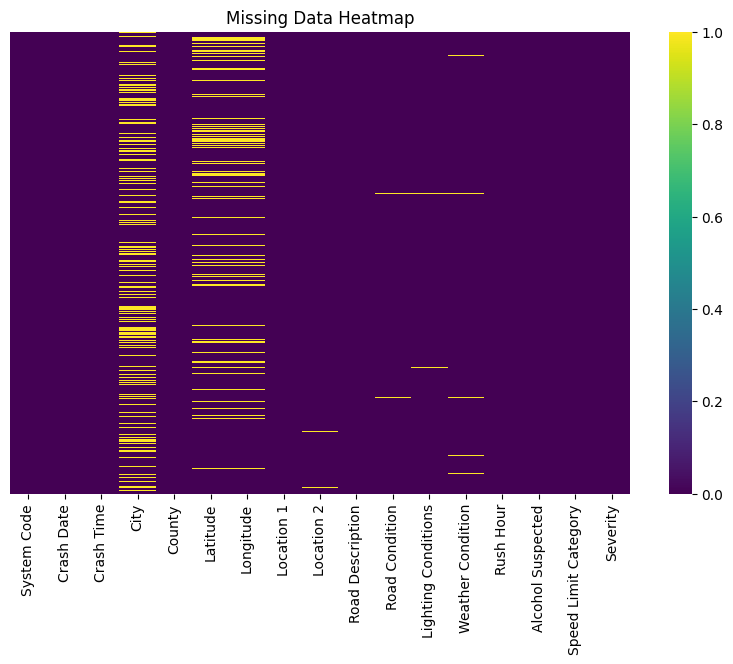

In [ ]:
missing = df.isna()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(missing, cbar=True, cmap="viridis", yticklabels=False)
plt.title("Missing Data Heatmap")
plt.show()

In [ ]:
missing_city = df[df["City"].isna()]
missing_lat_lon = df[df["Latitude"].isna() & df["Longitude"].isna()]
both_missing = missing_city[missing_city.index.isin(missing_lat_lon.index)]
print(f"Number of rows where both City and Latitude/Longitude are missing: {len(both_missing)}")
print(f"Number of rows where City is missing but Latitude/Longitude are not: {len(missing_city) - len(both_missing)}")
print(f"Number of rows where Latitude/Longitude are missing but City is not: {len(missing_lat_lon) - len(both_missing)}")

Number of rows where both City and Latitude/Longitude are missing: 5360
Number of rows where City is missing but Latitude/Longitude are not: 97800
Number of rows where Latitude/Longitude are missing but City is not: 47595


In [ ]:
valid_coords = df[df["Latitude"].notna() & df["Longitude"].notna() & df["City"].notna()]
city_coords = valid_coords.groupby("City", observed=False)[["Latitude", "Longitude"]].mean().to_dict("index")
print(f"Number of unique cities with valid coordinates in city_coords: {len(city_coords)}")
first_5 = dict(list(city_coords.items())[:5])
print(first_5)

Number of unique cities with valid coordinates in city_coords: 329
{'AKRON': {'Latitude': 40.15865124137931, 'Longitude': -103.20372406896553}, 'ALAMOSA': {'Latitude': 37.47274644442538, 'Longitude': -105.88748763722127}, 'ALLENSPARK': {'Latitude': 39.493, 'Longitude': -104.7562}, 'ALLISON': {'Latitude': 37.9249055, 'Longitude': -106.14672999999999}, 'ALMA': {'Latitude': 39.254275, 'Longitude': -106.03234}}


In [ ]:
from math import radians, sin, cos, sqrt, atan2
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

In [ ]:
def impute_city(row):
    if pd.isna(row["City"]):
        if pd.notna(row["Latitude"]) and pd.notna(row["Longitude"]):
            min_distance = float("inf")
            closest_city = None
            for city, coords in city_coords.items():
                distance = haversine_distance(row["Latitude"], row["Longitude"], coords["Latitude"], coords["Longitude"])
                if distance < min_distance:
                    min_distance = distance
                    closest_city = city
            return closest_city if closest_city else city_mode
        return city_mode
    return row["City"]

In [ ]:
city_mode = df["City"].mode()[0]
print(f"City mode for fallback: {city_mode}")

City mode for fallback: DENVER


In [ ]:
df["City"] = df.apply(impute_city, axis=1)
print(f"Number of remaining NaN values in City after imputation: {df['City'].isna().sum()}")  # Should be 0

Number of remaining NaN values in City after imputation: 0


In [ ]:
def impute_coords(row):
    if pd.isna(row["Latitude"]) or pd.isna(row["Longitude"]):
        city = row["City"]
        # Handle case sensitivity and unexpected values
        city = city.strip() if isinstance(city, str) else city_mode
        if pd.isna(city):
            city = city_mode
        if city in city_coords:
            return city_coords[city]["Latitude"], city_coords[city]["Longitude"]
        else:
            # not found in city_coords, falling back to overall mean
            return mean_lat, mean_lon
    return row["Latitude"], row["Longitude"]

In [ ]:
mean_lat = df["Latitude"].mean()
mean_lon = df["Longitude"].mean()
print(f"Fallback mean Latitude: {mean_lat:.4f}, Longitude: {mean_lon:.4f}")

Fallback mean Latitude: 39.5945, Longitude: -105.1800


In [ ]:
df[["Latitude", "Longitude"]] = df.apply(impute_coords, axis=1, result_type="expand")

In [ ]:
remaining_na = df[df["Latitude"].isna() | df["Longitude"].isna()]
if not remaining_na.empty:
    df = df.dropna(subset=["Latitude", "Longitude"])
print(f"Number of remaining NaN values in Latitude: {df['Latitude'].isna().sum()}")
print(f"Number of remaining NaN values in Longitude: {df['Longitude'].isna().sum()}")


Number of remaining NaN values in Latitude: 0
Number of remaining NaN values in Longitude: 0


In [ ]:
df["Crash Date"] = pd.to_datetime(df["Crash Date"], errors="coerce")
df["Month"] = df["Crash Date"].dt.month

In [ ]:
# Create a mapping of month to the most frequent Weather Condition
valid_weather = df[df["Weather Condition"].notna()]
weather_by_month = valid_weather.groupby("Month")["Weather Condition"].agg(lambda x: x.mode()[0]).to_dict()
print("Mapping of Month to Most Frequent Weather Condition:")
print(weather_by_month)

Mapping of Month to Most Frequent Weather Condition:
{1: 'Clear', 2: 'Clear', 3: 'Clear', 4: 'Clear', 5: 'Clear', 6: 'Clear', 7: 'Clear', 8: 'Clear', 9: 'Clear', 10: 'Clear', 11: 'Clear', 12: 'Clear'}


In [ ]:
categorical_missing_columns = [
    "County", "Location 1", "Location 2", "Road Description",
    "Road Condition", "Lighting Conditions", "Weather Condition","Alcohol Suspected",
    "Speed Limit Category", "Severity"
]
for col in categorical_columns:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)
    print(f"Imputed NaN values in {col} with mode: {mode_value}")

Imputed NaN values in System Code with mode: City Street
Imputed NaN values in City with mode: DENVER
Imputed NaN values in County with mode: DENVER
Imputed NaN values in Location 1 with mode: I-25
Imputed NaN values in Location 2 with mode: WADSWORTH BLVD
Imputed NaN values in Road Description with mode: Non-Intersection
Imputed NaN values in Road Condition with mode: Dry
Imputed NaN values in Lighting Conditions with mode: Daylight
Imputed NaN values in Weather Condition with mode: Clear
Imputed NaN values in Alcohol Suspected with mode: No
Imputed NaN values in Speed Limit Category with mode: Low
Imputed NaN values in Severity with mode: slight


In [ ]:
df.isna().sum()

System Code               0
Crash Date                0
Crash Time              719
City                      0
County                    0
Latitude                  0
Longitude                 0
Location 1                0
Location 2                0
Road Description          0
Road Condition            0
Lighting Conditions       0
Weather Condition         0
Rush Hour                 0
Alcohol Suspected         0
Speed Limit Category      0
Severity                  0
Month                     0
dtype: int64

In [ ]:
df = df.dropna(subset=["Crash Time"])

In [ ]:
df.isna().sum()

System Code             0
Crash Date              0
Crash Time              0
City                    0
County                  0
Latitude                0
Longitude               0
Location 1              0
Location 2              0
Road Description        0
Road Condition          0
Lighting Conditions     0
Weather Condition       0
Rush Hour               0
Alcohol Suspected       0
Speed Limit Category    0
Severity                0
Month                   0
dtype: int64

In [ ]:

output_file_path ="/content/drive/MyDrive/Dataset/data2.xlsx"
df.to_excel(output_file_path, index=False, engine="openpyxl")

<b>In which weather more accidents are happening<b>

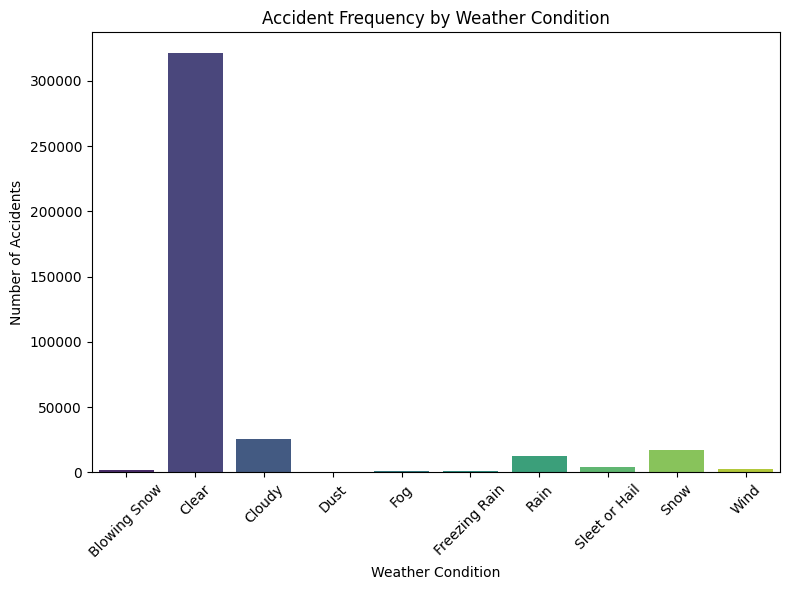

In [ ]:
weather_counts = df["Weather Condition"].value_counts().reset_index()
weather_counts.columns = ["Weather Condition", "Number of Accidents"]
weather_counts["Weather Condition"] = weather_counts["Weather Condition"].cat.rename_categories(
    {"Freezing Rain or Freezing Drizzle": "Freezing Rain"}
)

# Plot again
plt.figure(figsize=(8, 6))
sns.barplot(data=weather_counts, x="Weather Condition", y="Number of Accidents", hue="Weather Condition", palette="viridis", legend=False)
plt.title("Accident Frequency by Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<b>Observations:</b>More Accidents are seen in clear weather and then cloudy followed by snowy.

<b>On which day of the week(Monday, Tuesday, wednesday etc..) more accidents are happening</b>

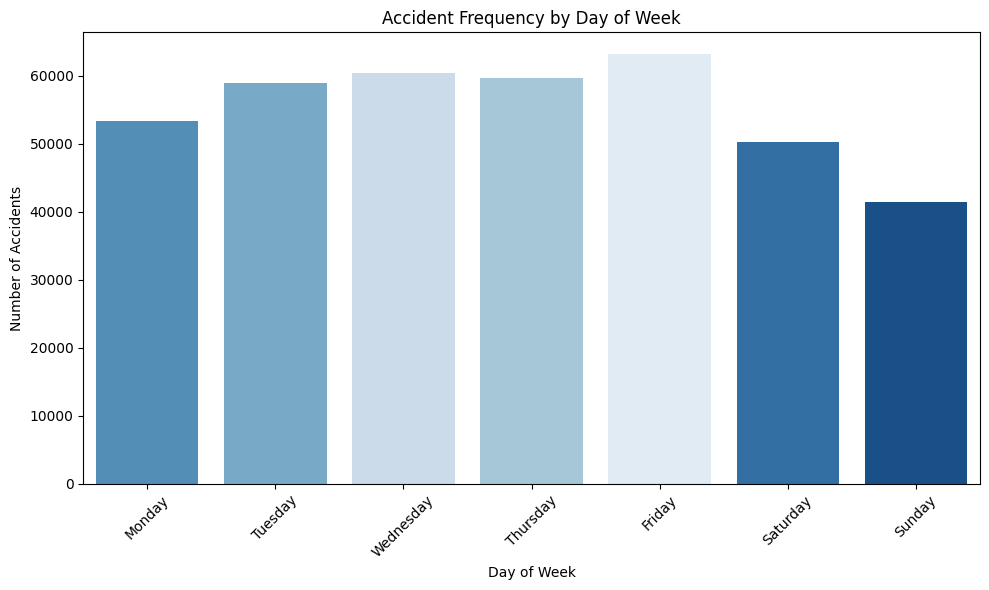

In [ ]:
df["Day of Week"] = df["Crash Date"].dt.day_name()
day_counts = df["Day of Week"].value_counts()
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]


plt.figure(figsize=(10, 6))
sns.barplot(x=day_counts.index, y=day_counts.values, order=days_order, hue=day_counts.index,  palette="Blues", legend=False )
plt.title("Accident Frequency by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<b>observations:</b>More Accidents are happening on friday, saturday,sunday.

<b> Factor Influencing Road Accident</b>

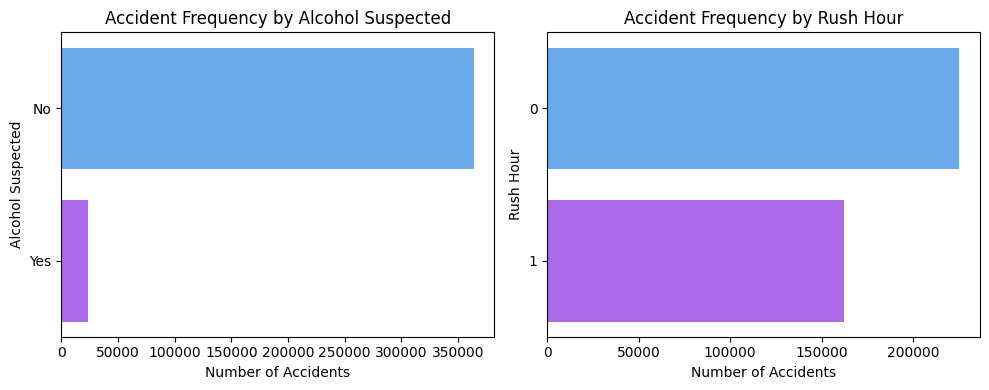

In [ ]:
binary_factors = ["Alcohol Suspected", "Rush Hour"]

plt.figure(figsize=(10, 4))
for i, factor in enumerate(binary_factors, 1):
    plt.subplot(1, 2, i)
    if factor == "Rush Hour":
        df[factor] = df[factor].astype(str)
    factor_counts = df[factor].value_counts()
    sns.barplot(x=factor_counts.values, y=factor_counts.index, hue=factor_counts.index, palette="cool", legend=False)
    plt.title(f"Accident Frequency by {factor}")
    plt.xlabel("Number of Accidents")
    plt.ylabel(factor)

plt.tight_layout()
plt.show()


<b> Observations:</b>  

*  The accidents are happening more under no influence of alcohol.
*  The accidents are happening during non rush hour



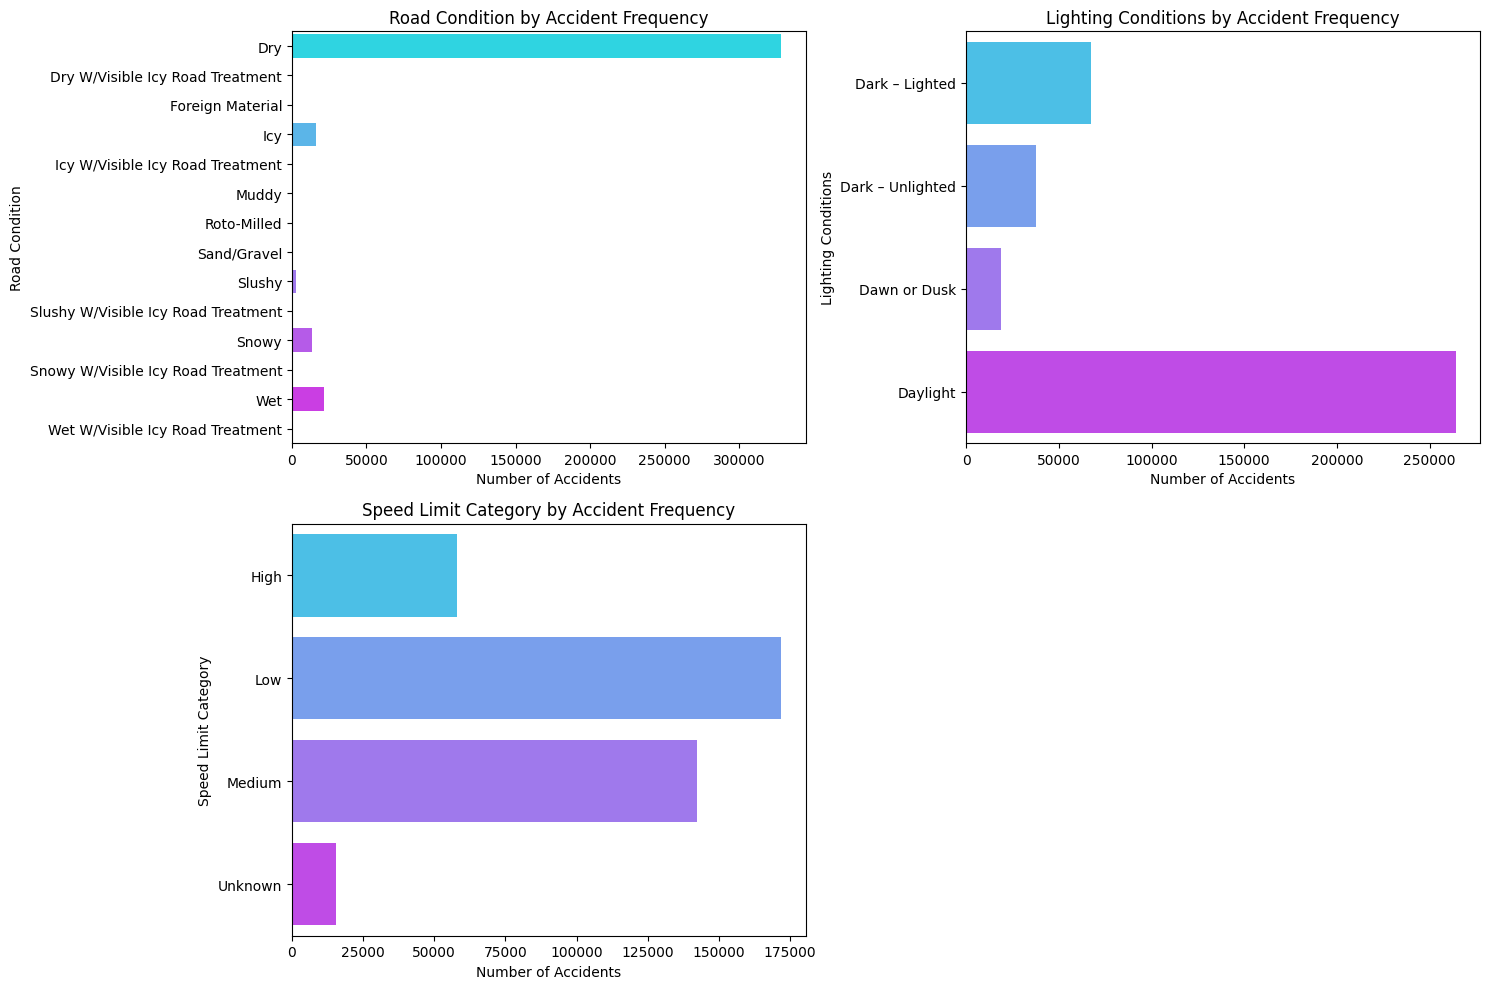

In [ ]:
non_binary_factors = ["Road Condition", "Lighting Conditions", "Speed Limit Category"]
plt.figure(figsize=(15, 10))
for i, factor in enumerate(non_binary_factors, 1):
    plt.subplot(2, 2, i)
    factor_counts = df[factor].value_counts().head(5)
    filtered_df = df[df[factor].isin(factor_counts.index)]
    factor_counts_filtered = filtered_df[factor].value_counts()
    sns.barplot(x=factor_counts_filtered.values, y=factor_counts_filtered.index, hue=factor_counts_filtered.index, palette="cool", legend=False)
    plt.title(f"{factor} by Accident Frequency")
    plt.xlabel("Number of Accidents")
    plt.ylabel(factor)
    plt.tight_layout()
plt.tight_layout()
plt.show()

Factors effecting more accidents in each feature
* Road condition: Dry, wet, Icy, snowy, slushy
* Lightening conditions: Day Light, dark-lightened, dark-unlightened, dawn
* SpeedLimit: Low, Medium, High, unknown



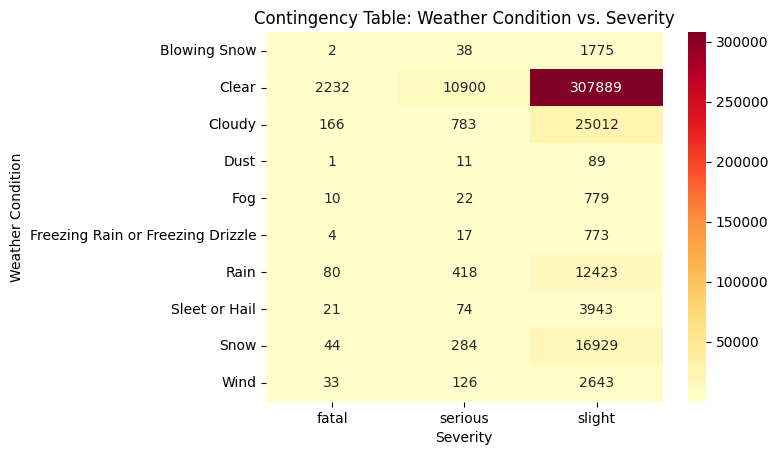

In [ ]:
contingency_table = pd.crosstab(df["Weather Condition"], df["Severity"])
sns.heatmap(contingency_table, annot=True, cmap="YlOrRd", fmt="d")
plt.title("Contingency Table: Weather Condition vs. Severity")
plt.show()

* We can see small accidents are happening during clear, cloudy, rainy, snowy weather
* serious accidents are happening during clear weather
* fata accidents are also happening during clear weather

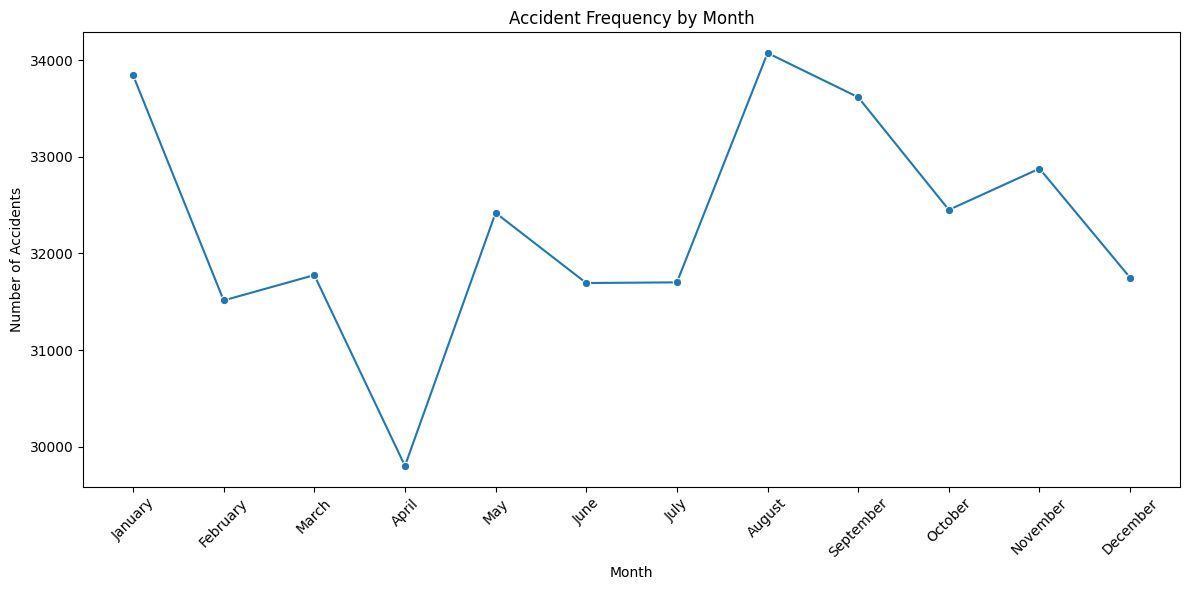

In [ ]:
df["Month"] = df["Crash Date"].dt.month_name()
month_counts = df["Month"].value_counts().reindex(["January", "February", "March", "April", "May", "June",
                                                 "July", "August", "September", "October", "November", "December"])
plt.figure(figsize=(12, 6))
sns.lineplot(x=month_counts.index, y=month_counts.values, marker="o")
plt.title("Accident Frequency by Month")
plt.xlabel("Month")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()